# JoinNode, synchronize and itersource

JoinNode has the opposite effect of [iterables](basic_iteration.ipynb). Where `iterables` split up the execution workflow into many different branches, a `JoinNode` merges them back into on node. A `JoinNode` generalizes `MapNode` to operate in conjunction with an upstream `iterable` node to reassemble downstream results, e.g.:

<img src="../static/images/joinnode.png"  width="240">

## Simple example

Let's consider the very simple example depicted at the top of this page:

```python
from nipype import Node, JoinNode, Workflow

# Specify fake input node A
a = Node(interface=A(), name="a")

# Iterate over fake node B's input 'in_file?
b = Node(interface=B(), name="b")
b.iterables = ('in_file', [file1, file2])

# Pass results on to fake node C
c = Node(interface=C(), name="c")

# Join forked execution workflow in fake node D
d = JoinNode(interface=D(),
             joinsource="b",
             joinfield="in_files",
             name="d")

# Put everything into a workflow as usual
workflow = Workflow(name="workflow")
workflow.connect([(a, b, [('subject', 'subject')]),
                  (b, c, [('out_file', 'in_file')])
                  (c, d, [('out_file', 'in_files')])
                  ])
```

As you can see, setting up a ``JoinNode`` is rather simple. The only difference to a normal ``Node`` is the ``joinsource`` and the ``joinfield``. ``joinsource`` specifies from which node the information to join is coming and the ``joinfield`` specifies the input field of the `JoinNode` where the information to join will be entering the node.

This example assumes that interface `A` has one output *subject*, interface `B` has two inputs *subject* and *in_file* and one output *out_file*, interface `C` has one input *in_file* and one output *out_file*, and interface `D` has one list input *in_files*. The *images* variable is a list of three input image file names.

As with *iterables* and the `MapNode` *iterfield*, the *joinfield* can be a list of fields. Thus, the declaration in the previous example is equivalent to the following:

```python
d = JoinNode(interface=D(),
             joinsource="b",
             joinfield=["in_files"],
             name="d")
```

The *joinfield* defaults to all of the JoinNode input fields, so the declaration is also equivalent to the following:

```python
d = JoinNode(interface=D(),
             joinsource="b",
             name="d")
```

In this example, the node `C` *out_file* outputs are collected into the `JoinNode` `D` *in_files* input list. The *in_files* order is the same as the upstream `B` node iterables order.

The `JoinNode` input can be filtered for unique values by specifying the *unique* flag, e.g.:

```python
d = JoinNode(interface=D(),
             joinsource="b",
             unique=True,
             name="d")
```

## `synchronize`

The `Node` `iterables` parameter can be be a single field or a list of fields. If it is a list, then execution is performed over all permutations of the list items. For example:

```python
b.iterables = [("m", [1, 2]), ("n", [3, 4])]
```

results in the execution graph:

<img src="../static/images/synchronize_1.png"  width="325">

where `B13` has inputs *m* = 1, *n* = 3, `B14` has inputs  *m* = 1, *n* = 4, etc.

The `synchronize` parameter synchronizes the iterables lists, e.g.:

```python
b.iterables = [("m", [1, 2]), ("n", [3, 4])]
b.synchronize = True
```

results in the execution graph:

<img src="../static/images/synchronize_2.png" width="160">

where the iterable inputs are selected in lock-step by index, i.e.:

    (*m*, *n*) = (1, 3) and (2, 4)

for `B13` and `B24`, resp.

## `itersource`

The `itersource` feature allows you to expand a downstream `iterable` based on a mapping of an upstream `iterable`. For example:

```python
a = Node(interface=A(), name="a")
b = Node(interface=B(), name="b")
b.iterables = ("m", [1, 2])
c = Node(interface=C(), name="c")
d = Node(interface=D(), name="d")
d.itersource = ("b", "m")
d.iterables = [("n", {1:[3,4], 2:[5,6]})]
my_workflow = Workflow(name="my_workflow")
my_workflow.connect([(a,b,[('out_file','in_file')]),
                     (b,c,[('out_file','in_file')])
                     (c,d,[('out_file','in_file')])
                     ])
```

results in the execution graph:

<img src="../static/images/itersource_1.png" width="350">

In this example, all interfaces have input `in_file` and output `out_file`. In addition, interface `B` has input *m* and interface `D` has input *n*. A Python dictionary associates the `B` node input value with the downstream `D` node *n* iterable values.

This example can be extended with a summary `JoinNode`:

```python
e = JoinNode(interface=E(), joinsource="d",
             joinfield="in_files", name="e")
my_workflow.connect(d, 'out_file',
                    e, 'in_files')
```

resulting in the graph:

<img src="../static/images/itersource_2.png" width="350">

The combination of `iterables`, `MapNode`, `JoinNode`, `synchronize` and `itersource` enables the creation of arbitrarily complex workflow graphs. The astute workflow builder will recognize that this flexibility is both a blessing and a curse. These advanced features are handy additions to the Nipype toolkit when used judiciously.

## More realistic `JoinNode` example

Let's consider another example where we have one node that iterates over 3 different numbers and generates random numbers. Another node joins those three different numbers (each coming from a separate branch of the workflow) into one list. To make the whole thing a bit more realistic, the second node will use the ``Function`` interface to do something with those numbers, before we spit them out again.

In [1]:
from nipype import JoinNode, Node, Workflow
from nipype.interfaces.utility import Function, IdentityInterface

In [2]:
def get_data_from_id(id):
    """Generate a random number based on id"""
    import numpy as np
    return id + np.random.rand()

def merge_and_scale_data(data2):
    """Scale the input list by 1000"""
    import numpy as np
    return (np.array(data2) * 1000).tolist()


node1 = Node(Function(input_names=['id'],
                      output_names=['data1'],
                      function=get_data_from_id),
             name='get_data')
node1.iterables = ('id', [1, 2, 3])

node2 = JoinNode(Function(input_names=['data2'],
                          output_names=['data_scaled'],
                          function=merge_and_scale_data),
                 name='scale_data',
                 joinsource=node1,
                 joinfield=['data2'])

In [3]:
wf = Workflow(name='testjoin')
wf.connect(node1, 'data1', node2, 'data2')
eg = wf.run()

211017-17:58:34,755 nipype.workflow INFO:
	 Workflow testjoin settings: ['check', 'execution', 'logging', 'monitoring']
211017-17:58:34,793 nipype.workflow INFO:
	 Running serially.
211017-17:58:34,796 nipype.workflow INFO:
	 [Node] Setting-up "testjoin.get_data" in "/tmp/tmpd947muth/testjoin/_id_3/get_data".
211017-17:58:34,801 nipype.workflow INFO:
	 [Node] Running "get_data" ("nipype.interfaces.utility.wrappers.Function")
211017-17:58:34,820 nipype.workflow INFO:
	 [Node] Finished "testjoin.get_data".
211017-17:58:34,821 nipype.workflow INFO:
	 [Node] Setting-up "testjoin.get_data" in "/tmp/tmpa65pphaq/testjoin/_id_2/get_data".
211017-17:58:34,826 nipype.workflow INFO:
	 [Node] Running "get_data" ("nipype.interfaces.utility.wrappers.Function")
211017-17:58:34,833 nipype.workflow INFO:
	 [Node] Finished "testjoin.get_data".
211017-17:58:34,834 nipype.workflow INFO:
	 [Node] Setting-up "testjoin.get_data" in "/tmp/tmpyp62y5dz/testjoin/_id_1/get_data".
211017-17:58:34,842 nipype.workfl

211017-17:58:35,132 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/workshop_weizmann/workshop/nipype/notebooks/graph.png (graph2use=exec, simple_form=True).


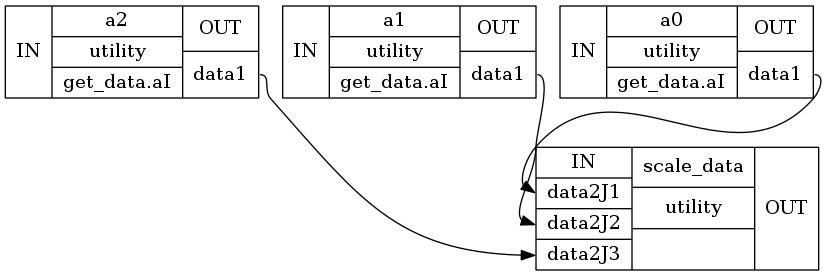

In [4]:
wf.write_graph(graph2use='exec')
from IPython.display import Image
Image(filename='graph_detailed.png')

Now, let's look at the input and output of the joinnode:

In [5]:
res = [node for node in eg.nodes() if 'scale_data' in node.name][0].result
res.outputs


data_scaled = [1217.0315662669173, 2744.9636514899635, 3046.9774571686444]

In [6]:
res.inputs

{'function_str': 'def merge_and_scale_data(data2):\n    """Scale the input list by 1000"""\n    import numpy as np\n    return (np.array(data2) * 1000).tolist()\n',
 'data2': [1.2170315662669173, 2.7449636514899636, 3.0469774571686443]}

## Extending to multiple nodes

We extend the workflow by using three nodes. Note that even this workflow, the joinsource corresponds to the node containing iterables and the joinfield corresponds to the input port of the JoinNode that aggregates the iterable branches. As before the graph below shows how the execution process is set up.

In [7]:
def get_data_from_id(id):
    import numpy as np
    return id + np.random.rand()

def scale_data(data2):
    import numpy as np
    return data2

def replicate(data3, nreps=2):
    return data3 * nreps

node1 = Node(Function(input_names=['id'],
                      output_names=['data1'],
                      function=get_data_from_id),
             name='get_data')
node1.iterables = ('id', [1, 2, 3])

node2 = Node(Function(input_names=['data2'],
                      output_names=['data_scaled'],
                      function=scale_data),
             name='scale_data')

node3 = JoinNode(Function(input_names=['data3'],
                          output_names=['data_repeated'],
                          function=replicate),
                 name='replicate_data',
                 joinsource=node1,
                 joinfield=['data3'])

In [8]:
wf = Workflow(name='testjoin')
wf.connect(node1, 'data1', node2, 'data2')
wf.connect(node2, 'data_scaled', node3, 'data3')
eg = wf.run()

211017-17:58:35,220 nipype.workflow INFO:
	 Workflow testjoin settings: ['check', 'execution', 'logging', 'monitoring']
211017-17:58:35,283 nipype.workflow INFO:
	 Running serially.
211017-17:58:35,285 nipype.workflow INFO:
	 [Node] Setting-up "testjoin.get_data" in "/tmp/tmpwedf30h4/testjoin/_id_3/get_data".
211017-17:58:35,295 nipype.workflow INFO:
	 [Node] Running "get_data" ("nipype.interfaces.utility.wrappers.Function")
211017-17:58:35,303 nipype.workflow INFO:
	 [Node] Finished "testjoin.get_data".
211017-17:58:35,305 nipype.workflow INFO:
	 [Node] Setting-up "testjoin.scale_data" in "/tmp/tmpbs5eiex1/testjoin/_id_3/scale_data".
211017-17:58:35,312 nipype.workflow INFO:
	 [Node] Running "scale_data" ("nipype.interfaces.utility.wrappers.Function")
211017-17:58:35,323 nipype.workflow INFO:
	 [Node] Finished "testjoin.scale_data".
211017-17:58:35,326 nipype.workflow INFO:
	 [Node] Setting-up "testjoin.get_data" in "/tmp/tmp5lx_f4ju/testjoin/_id_2/get_data".
211017-17:58:35,331 nipyp

211017-17:58:35,704 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/workshop_weizmann/workshop/nipype/notebooks/graph.png (graph2use=exec, simple_form=True).


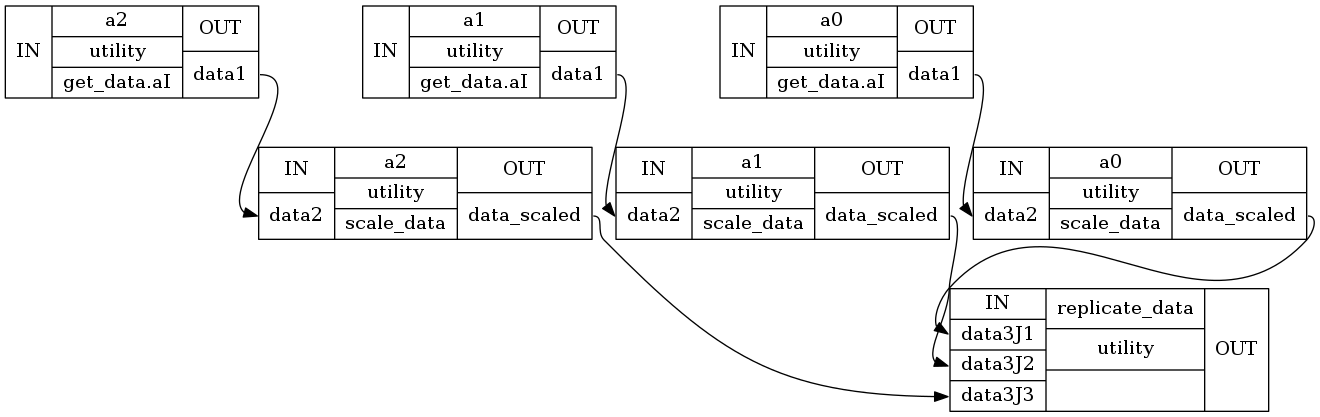

In [9]:
wf.write_graph(graph2use='exec')
Image(filename='graph_detailed.png')

### Exercise 1

You have list of DOB of the subjects in a few various format : ``["10 February 1984", "March 5 1990", "April 2 1782", "June 6, 1988", "12 May 1992"]``, and you want to sort the list.

You can use ``Node`` with ``iterables`` to extract day, month and year, and use [datetime.datetime](https://docs.python.org/2/library/datetime.html) to unify the format that can be compared, and ``JoinNode`` to sort the list.

In [10]:
# write your solution here

In [11]:
# the list of all DOB
dob_subjects = ["10 February 1984", "March 5 1990", "April 2 1782", "June 6, 1988", "12 May 1992"]

In [12]:
# let's start from creating Node with iterable to split all strings from the list
from nipype import Node, JoinNode, Function, Workflow

def split_dob(dob_string):
    return dob_string.split()

split_node = Node(Function(input_names=["dob_string"], 
                              output_names=["split_list"], 
                              function=split_dob),
                    name="splitting")

#split_node.inputs.dob_string = "10 February 1984"
split_node.iterables = ("dob_string", dob_subjects)

In [13]:
# and now let's work on the date format more, independently for every element

# sometimes the second element has an extra "," that we should remove
def remove_comma(str_list):
    str_list[1] = str_list[1].replace(",", "")
    return str_list

cleaning_node = Node(Function(input_names=["str_list"], 
                              output_names=["str_list_clean"], 
                              function=remove_comma),
                    name="cleaning")


# now we can extract year, month, day from our list and create ``datetime.datetim`` object
def datetime_format(date_list):
    import datetime
    # year is always the last
    year = int(date_list[2])
    #day and month can be in the first or second position
    # we can use datetime.datetime.strptime to convert name of the month to integer
    try:
        day = int(date_list[0])
        month = datetime.datetime.strptime(date_list[1], "%B").month
    except(ValueError):
        day = int(date_list[1])
        month = datetime.datetime.strptime(date_list[0], "%B").month
    # and create datetime.datetime format
    return datetime.datetime(year, month, day)


datetime_node = Node(Function(input_names=["date_list"], 
                                  output_names=["datetime"], 
                              function=datetime_format),
                    name="datetime")
    

In [14]:
# now we are ready to create JoinNode and sort the list of DOB

def sorting_dob(datetime_list):
    datetime_list.sort()
    return datetime_list

sorting_node = JoinNode(Function(input_names=["datetime_list"], 
                              output_names=["dob_sorted"], 
                              function=sorting_dob),
                    joinsource=split_node, # this is the node that used iterables for x
                    joinfield=['datetime_list'],
                    name="sorting")


In [15]:
# and we're ready to create workflow

ex1_wf = Workflow(name="sorting_dob")
ex1_wf.connect(split_node, "split_list", cleaning_node, "str_list")
ex1_wf.connect(cleaning_node, "str_list_clean", datetime_node, "date_list")
ex1_wf.connect(datetime_node, "datetime", sorting_node, "datetime_list")

211017-17:58:36,124 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/workshop_weizmann/workshop/nipype/notebooks/graph.png (graph2use=exec, simple_form=True).


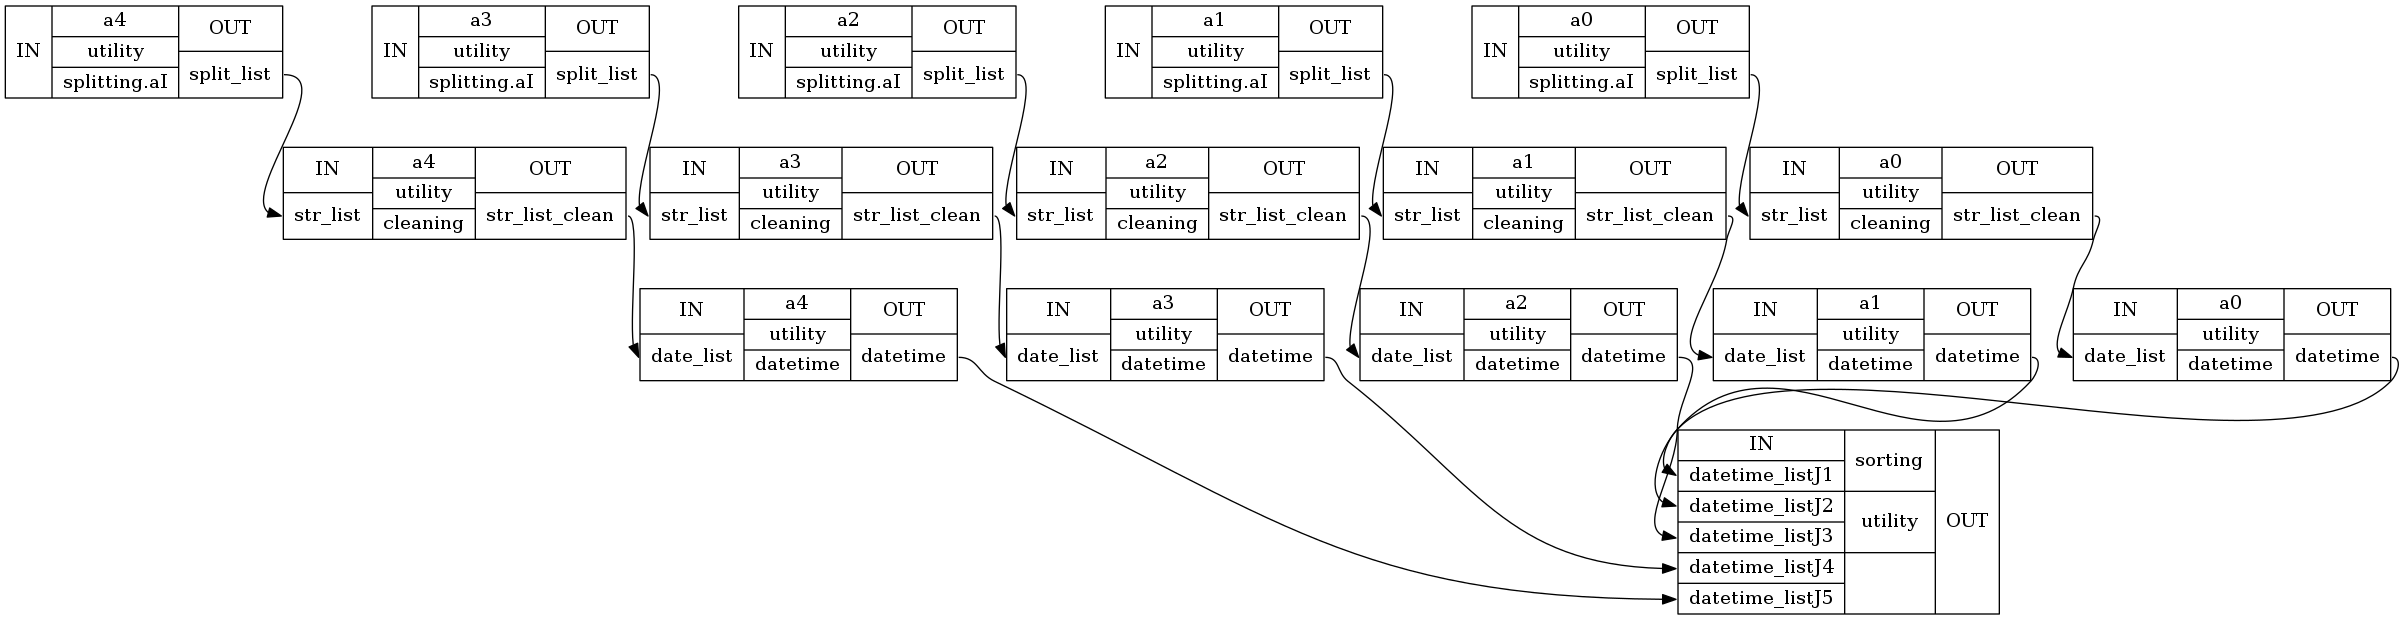

In [16]:
# you can check the graph
from IPython.display import Image
ex1_wf.write_graph(graph2use='exec')
Image(filename='graph_detailed.png')

In [17]:
# and run the workflow
ex1_res = ex1_wf.run()

211017-17:58:36,146 nipype.workflow INFO:
	 Workflow sorting_dob settings: ['check', 'execution', 'logging', 'monitoring']
211017-17:58:36,196 nipype.workflow INFO:
	 Running serially.
211017-17:58:36,198 nipype.workflow INFO:
	 [Node] Setting-up "sorting_dob.splitting" in "/tmp/tmpa0k7vtmz/sorting_dob/_dob_string_12May1992/splitting".
211017-17:58:36,203 nipype.workflow INFO:
	 [Node] Running "splitting" ("nipype.interfaces.utility.wrappers.Function")
211017-17:58:36,211 nipype.workflow INFO:
	 [Node] Finished "sorting_dob.splitting".
211017-17:58:36,212 nipype.workflow INFO:
	 [Node] Setting-up "sorting_dob.cleaning" in "/tmp/tmpgmwqmi56/sorting_dob/_dob_string_12May1992/cleaning".
211017-17:58:36,218 nipype.workflow INFO:
	 [Node] Running "cleaning" ("nipype.interfaces.utility.wrappers.Function")
211017-17:58:36,228 nipype.workflow INFO:
	 [Node] Finished "sorting_dob.cleaning".
211017-17:58:36,230 nipype.workflow INFO:
	 [Node] Setting-up "sorting_dob.datetime" in "/tmp/tmpqbe44hu6

In [18]:
# you can check list of all nodes
ex1_res.nodes()

NodeView((sorting_dob.sorting, sorting_dob.splitting.aI.a0, sorting_dob.cleaning.a0, sorting_dob.datetime.a0, sorting_dob.splitting.aI.a1, sorting_dob.cleaning.a1, sorting_dob.datetime.a1, sorting_dob.splitting.aI.a2, sorting_dob.cleaning.a2, sorting_dob.datetime.a2, sorting_dob.splitting.aI.a3, sorting_dob.cleaning.a3, sorting_dob.datetime.a3, sorting_dob.splitting.aI.a4, sorting_dob.cleaning.a4, sorting_dob.datetime.a4))

In [19]:
# and check the results from sorting_dob.sorting
list(ex1_res.nodes())[0].result.outputs


dob_sorted = [datetime.datetime(1782, 4, 2, 0, 0), datetime.datetime(1984, 2, 10, 0, 0), datetime.datetime(1988, 6, 6, 0, 0), datetime.datetime(1990, 3, 5, 0, 0), datetime.datetime(1992, 5, 12, 0, 0)]